In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Tuple

This notebook is about experimental approximation of the continuos function $f(x)$ defined on $[0,1]$ with a linear combination of the form
$$g(x; \theta) = c_0 + \sum_{i=1}^n \alpha_i \sigma(\beta_i x + c_i)$$
where $\sigma(x)=\frac{1}{1+e^{-x}}$ is a standard sigmoid function, and our parameters are $\theta = (c_0, c_1 \dots, c_n, \alpha_1, \dots, \alpha_n, \beta_1, \dots, \beta_n)$. Idea is to follow Cybenko result.

In [2]:
def target_function(x: np.ndarray) -> np.ndarray:
    return x * x

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [3]:
train_X = np.linspace(0.0, 1.0, 101)
train_Y = target_function(train_X)

print(train_X[0:2])
print(train_X[-2:])

[0.   0.01]
[0.99 1.  ]


In [4]:
def plot_approximation(X: np.ndarray, Y: np.ndarray, pred_Y: np.ndarray) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # Left: target vs approximation
    ax0 = axes[0]
    ax0.plot(X, Y, alpha=0.6, label='target')
    ax0.plot(X, pred_Y, color='red', label='approximation')
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')
    ax0.set_title('Target & approximation')
    ax0.legend()
    ax0.grid(True)

    # Right: difference Y - pred_Y
    ax1 = axes[1]
    diff = Y - pred_Y
    ax1.plot(X, diff, color='purple', label='Y - pred_Y')
    ax1.axhline(0.0, color='black', linewidth=0.8)
    ax1.set_xlabel('x')
    ax1.set_ylabel('difference')
    ax1.set_title('Error (Y - approx)')
    ax1.legend()
    ax1.grid(True)

    plt.tight_layout()
    plt.show()

**First we start with $n=1$:**

$$g_1(x; \theta) = g_1(x; c_0, c_1, \alpha_1, \beta_1) = c_0 + \alpha_1 \sigma(\beta_1 x + c_1)$$

In [5]:
def g1(x, params):
    """
    Compute g(x; params).
    - params is tuple/list (c0, c1, alpha1, beta1) for n=1
    - x is a numpy array
    """

    c0, c1, alpha1, beta1 = params
    z = beta1 * x + c1
    s = sigmoid(z)
    return c0 + alpha1 * s


def max_error_g1(params) -> float:
    """
    Compute maximal absolute error |g_1(train_X; params) - train_Y| over train_X.
    """
    preds = g1(train_X, params)
    return float(np.max(np.abs(preds - train_Y)))

We start with a simple iteration over some grid of possible values of parameter.

In [6]:
def solve_best_c0(
    alpha1: float,
    beta1: float,
    c1: float,
    X: np.ndarray,
    Y: np.ndarray,
) -> Tuple[float, float, float]:
    """
    For a fixed (alpha1, beta1, c1), choose c0 that minimizes L_inf on (X, Y).
    Let r_i = alpha1 * sigmoid(beta1 * X_i + c1) - Y_i. Then
      c0* = - (max_i r_i + min_i r_i) / 2
      min L_inf = (max_i r_i - min_i r_i) / 2
    Returns (best_c0, best_linf).
    """
    S = sigmoid(beta1 * X + c1)
    R = alpha1 * S - Y

    r_min = R.min(axis=0)
    r_max = R.max(axis=0)

    return -0.5 * (r_max + r_min), 0.5 * (r_max - r_min)

def grid_search_g1(
    X: np.ndarray,
    Y: np.ndarray,
    points: int,
) -> Dict[str, float]:
    """
    Perform grid search over alpha1, beta1, c1. For each (alpha1, beta1, c1),
    choose the best (c0) by minimizing L_inf error.

    Returns a dict with keys: 'alpha1', 'beta1', 'c1', 'c0', 'error'.
    """

    alpha_range: Tuple[float, float] = (-10.0, 10.0)
    beta_range: Tuple[float, float] = (-10.0, 10.0)
    c1_range: Tuple[float, float] = (-10.0, 10.0)

    alpha_grid = np.linspace(alpha_range[0], alpha_range[1], points)
    beta_grid = np.linspace(beta_range[0], beta_range[1], points)
    c1_grid = np.linspace(c1_range[0], c1_range[1], points)

    best = {
        'params': None,
        'error': np.inf,
    }

    for alpha1 in alpha_grid:
        for beta1 in beta_grid:
            for c1 in c1_grid:
                c0, error = solve_best_c0(alpha1, beta1, c1, X, Y)
                if error < best['error']:
                    best['params'] = (float(c0), float(c1), float(alpha1), float(beta1))
                    best['error'] = float(error)

    return best

In [7]:
best = grid_search_g1(train_X, train_Y, points=100)
print(f"Best: {best}")

pred_Y = g1(train_X, best['params'])

Best: {'params': (1.856935168682477, 3.5353535353535346, -1.9191919191919187, -3.737373737373738), 'error': 0.009069506156555551}


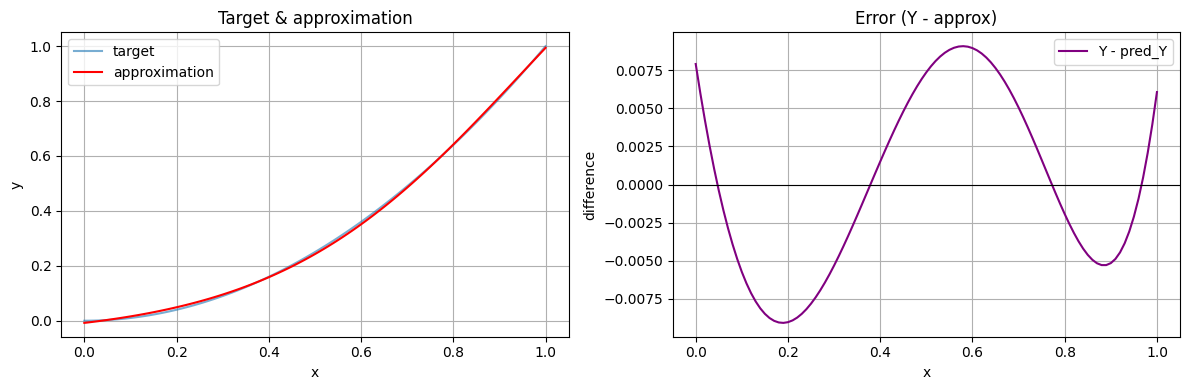

In [8]:
plot_approximation(train_X, train_Y, pred_Y)

### L∞ Approximation via Subgradient Method
We minimize $\|e(\theta)\|_\infty = \max_i |e_i(\theta)|$ where $e_i(\theta) = g(x_i;\theta) - y_i$.
For a subgradient, pick $i^* = \arg\max_i |e_i(\theta)|$ and step against $\nabla_\theta |e_{i^*}(\theta)| = \operatorname{sign}(e_{i^*})\, \nabla_\theta g(x_{i^*};\theta)$.
Model: $g(x;\theta) = c_0 + \sum_{j=1}^n \alpha_j\, \sigma(\beta_j x + c_j)$ with $\sigma(z) = 1/(1+e^{-z})$.
Derivatives at a single sample $x$ with $u_j = \beta_j x + c_j$ and $\sigma'(u_j) = \sigma(u_j)(1-\sigma(u_j))$:
- $\partial g/\partial c_0 = 1$
- $\partial g/\partial \alpha_j = \sigma(u_j)$
- $\partial g/\partial \beta_j = \alpha_j\,\sigma'(u_j)\,x$
- $\partial g/\partial c_j = \alpha_j\,\sigma'(u_j)$
We use diminishing stepsize $\eta_t = \eta_0/\sqrt{t+1}$ and clip parameters to keep numerics stable.

In [9]:
import numpy as np
from typing import Dict, Tuple

def g_predict(x: np.ndarray, theta: Dict[str, np.ndarray]) -> np.ndarray:
    """Compute g(x; theta) for vector x using the notebook's sigmoid."""
    c0 = theta['c0']
    alpha = theta['alpha']  # shape (n,)
    beta = theta['beta']    # shape (n,)
    c = theta['c']          # shape (n,)
    # Broadcast to (len(x), n)
    Z = np.outer(x, beta) + c  # (len(x), n)
    S = sigmoid(Z)             # (len(x), n)
    return c0 + (S * alpha).sum(axis=1)

def init_theta(n: int, seed: int = 42) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)
    return {
        'c0': 0.0,
        'alpha': rng.normal(0.0, 0.1, size=(n,)),
        'beta': rng.normal(0.0, 0.1, size=(n,)),
        'c': rng.normal(0.0, 0.1, size=(n,)),
    }

def linf_subgradient_step(theta: Dict[str, np.ndarray], X: np.ndarray, Y: np.ndarray, t: int, lr0: float, clip: float = 8.0) -> Tuple[Dict[str, np.ndarray], float, int]:
    """
    Perform one subgradient step for L_inf norm on dataset (X, Y).
    Returns: (updated_theta, max_err, argmax_index)
    """
    # Current errors and argmax
    preds = g_predict(X, theta)
    E = preds - Y
    idx = int(np.argmax(np.abs(E)))
    x = float(X[idx])
    y = float(Y[idx])
    # Subgradient at the worst sample
    Z = theta['beta'] * x + theta['c']           # (n,)
    S = sigmoid(Z)                               # (n,)
    Sp = S * (1.0 - S)                           # (n,)
    e = float((theta['c0'] + (S * theta['alpha']).sum()) - y)
    sgn = 1.0 if e >= 0.0 else -1.0
    # Diminishing stepsize
    eta = lr0 / np.sqrt(t + 1.0)
    # Gradients
    grad_c0 = sgn
    grad_alpha = sgn * S                         # (n,)
    grad_beta = sgn * (theta['alpha'] * Sp * x)  # (n,)
    grad_c = sgn * (theta['alpha'] * Sp)         # (n,)
    # Update
    theta['c0'] = theta['c0'] - eta * grad_c0
    theta['alpha'] = theta['alpha'] - eta * grad_alpha
    theta['beta'] = theta['beta'] - eta * grad_beta
    theta['c'] = theta['c'] - eta * grad_c
    # Clip to keep numerics stable
    theta['alpha'] = np.clip(theta['alpha'], -clip, clip)
    theta['beta'] = np.clip(theta['beta'], -clip, clip)
    theta['c'] = np.clip(theta['c'], -clip, clip)
    return theta, float(np.max(np.abs(E))), idx

def minimize_linf_subgradient(X: np.ndarray, Y: np.ndarray, n: int = 1, steps: int = 5000, lr0: float = 0.1, seed: int = 42, clip: float = 8.0) -> Dict[str, np.ndarray]:
    theta = init_theta(n, seed)
    history = []
    argmax_indices = []
    for t in range(steps):
        theta, max_err, idx = linf_subgradient_step(theta, X, Y, t, lr0, clip)
        history.append(max_err)
        argmax_indices.append(idx)
    return {
        'theta': theta,
        'history': np.array(history),
        'argmax_indices': np.array(argmax_indices),
        'preds': g_predict(X, theta),
    }

# Example run for n=1
n = 1
result = minimize_linf_subgradient(train_X, train_Y, n=n, steps=3000, lr0=0.2, seed=123)
print('Final L_inf error:', np.max(np.abs(result['preds'] - train_Y)))
print('Theta:', result['theta'])

Final L_inf error: 0.48121444405249886
Theta: {'c0': np.float64(0.26434858090917285), 'alpha': array([0.4153198]), 'beta': array([0.44765421]), 'c': array([0.08362927])}
